# Mode Sorter

##  Simulation Parameters

In [1]:
import Propagation as pg
import ModeGeneration as mg
import BasicFunctions as bf
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

# Simulation parameters
N = 128  # pixel number
L = 0.0015 # grid size [m]
w = 50e-6  # width of input [m]
w_prime = 100e-6  # width of output [m]
delta = L / N  # pixel size [m]
wvl = 633e-9  # optical wavelength [m]
z = 0.020 # distance between phase masks [m]
angle= 5


num_planes =5
num_modes = 3

maskOffset = np.sqrt(1e-3 / (N * N * num_modes)) * 0.3

# Space grid
x = np.linspace(-N / 2, N / 2 - 1, N) * delta
y = np.linspace(-N / 2, N / 2 - 1, N) * delta * 1/np.cos(np.deg2rad(angle))
x, y = np.meshgrid(x, y)

TH,R = bf.cart2pol(x,y)
x0,y0 = bf.pol2cart(TH-np.pi/4,R)


d = 2e-4 *1.2# Distance between the beams [m]
central_shift = 2e-4*1.5 #location of top beam [m]

def create_gaussian_beams_array(x, y, w, d, central_shift, num_beams):
    beams = []
    beam_count = 0
    layer = 0

    while beam_count < num_beams:
        # Calculate the starting position for the current layer
        start_x = x - layer * d / 2
        start_y = y + central_shift - layer * np.sqrt(3) * d / 2

        # Generate beams in the current layer
        for i in range(layer + 1):
            if beam_count >= num_beams:
                break
            beam_x = start_x + i * d
            beam_y = start_y
            beams.append(mg.hg_mode(beam_x, beam_y, w, 0, 0))
            beam_count += 1

        # Move to the next layer
        layer += 1

    return beams[:num_beams]


all_gaussian_beams = sum(create_gaussian_beams_array(x, y, w, d, central_shift, num_modes))



# Generate HG modes
def generate_hg_modes_array(x, y, w_prime, mode_count):
    modes = []
    index = 0
    for m in range(mode_count + 1):
        for n in range(m + 1):
            if index >= mode_count:
                return modes
            mode = mg.hg_mode(x, y, w_prime, m - n, n)
            modes.append(mode)
            index += 1
    return modes



input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)
output_modes = generate_hg_modes_array(x0, y0, w_prime,num_modes)

#output_modes = mg.sort_and_limit_lg_modes(mg.generate_lg_modes_array(x0, y0, w_prime,3,3),num_modes)


# Transfer function of free-space propagation
H0 = bf.transfer_function_of_free_space(x, y, z, wvl)

# Phase masks
mask = np.exp(1j * np.angle(np.ones((N, N))))
phase_masks = []
for i in range(num_planes):
    phase_masks.append(mask)







$k_{x,\text{max}} \approx \frac{1}{2\,\Delta x}, \qquad \Delta k_x = \frac{1}{L_x} = \frac{1}{N_x\,\Delta x}\,.$


To accurately capture and reconstruct the optical field, it is crucial that the discrete grid (both in real space and in \(k\)-space) is dense enough. Even though the frequency range is set by the pixel size$\Delta x$, if the number of pixels $N_x$ (and similarly $N_y$ is too small, the frequency grid in $k$-space will be coarse. This coarse sampling can miss or misrepresent the highest spatial frequency components in the field, resulting in aliasing artifacts. 

Thus, while the pixel size defines the maximum frequency you can in principle capture, the number of pixels must be large enough so that the DFT grid has a fine enough resolution to accurately resolve the details (the finest structures) in the optical field.

Compute maximum spacing

\begin{equation}
d \ll \frac{16\,\Delta x^4}{\lambda^3}
\end{equation}



In [ ]:

spacing= (16*(delta)**4)/(wvl)**3
spacing*1000 #[mm]

## Checking Parameters

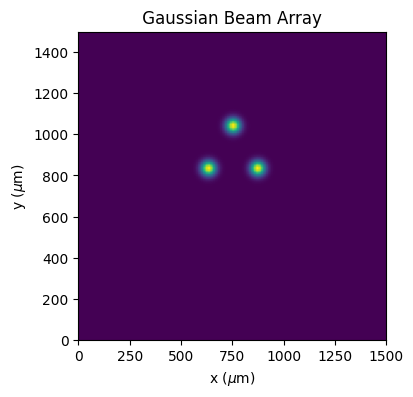

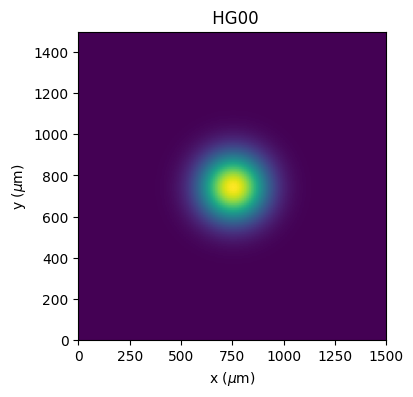

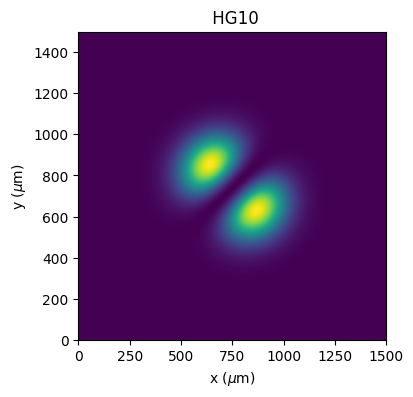

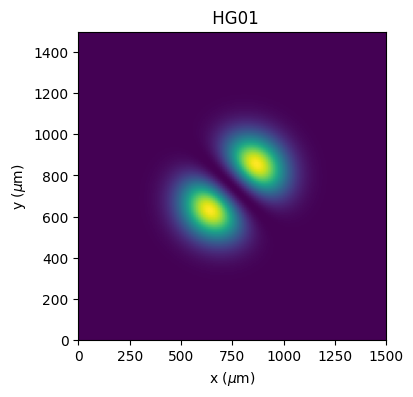

In [64]:
# Define extent for physical dimensions
extent = [0, N * delta*10**6, 0, N * delta*10**6] 
# Plot the intensity of the Gaussian beams
plt.figure(figsize=(4, 4))
plt.imshow(np.abs(all_gaussian_beams) ** 2, cmap="viridis",extent=extent)
plt.title(r' Gaussian Beam Array ')
plt.xlabel(r'x ($\mu$m)')
plt.ylabel(r'y ($\mu$m)')
#plt.axis('off')  # Remove axis
#pt.savefig("Gaussian_Beams.png", bbox_inches='tight', dpi=400) 
plt.show()


# Plot the Modes
labels = ['HG00', 'HG10', 'HG01', 'HG20', 'HG11', 'HG02', 'HG30', 'HG21', 'HG12', 'HG03']
for i in range(len(output_modes)):
    plt.figure(figsize=(4, 4))
    plt.imshow(np.abs(output_modes[i]) ** 2,  cmap="viridis",extent=extent)
    #plt.axis('off')  # Remove axis
    #plt.savefig(f"{labels[i]}.png", bbox_inches='tight', dpi=400)     
    plt.title(f' {labels[i]}')
    plt.xlabel(r'x ($\mu$m)')
    plt.ylabel(r'y ($\mu$m)')
    plt.show()

## Wavefront Matching Algo.

In [3]:
opt_list=[]
num_iterations = 40

for iteration in range(num_iterations):
    
    output_modes = generate_hg_modes_array(x0, y0, w_prime,num_modes) #backward
    input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)  #forward
    
    for distance_z in range(len(phase_masks), 0, -1):
        # Reset the output modes for each distance_z
        output_modes = generate_hg_modes_array(x0, y0, w_prime,num_modes) #backward

        # Reverse loop through the phase masks based on the current distance_z
        for i in range(len(phase_masks) - 1, len(phase_masks) - distance_z , -1):
            # First, bf.propagate the output modes
            output_modes = [bf.propagate(output_mode, np.conj(H0)) for output_mode in output_modes]
            # Apply the current phase mask and bf.propagate again
            output_modes = [output_mode * np.exp(1j*np.angle(phase_masks[i])) for output_mode in output_modes]

        # Final propagation for output_modes at the current distance_z
        output_modes_at_mask = [bf.propagate(output_mode, np.conj(H0))  for output_mode in output_modes]
        pwr_output_modes_at_mask = [np.sum(np.abs(np.conj(modes))**2)  for modes in output_modes_at_mask]

        # bf.propagate the input modes
        input_modes_at_mask = [bf.propagate(input_mode, H0)  for input_mode in input_modes]
        pwr_input_modes_at_mask = [np.sum(np.abs(modes)**2)  for modes in input_modes_at_mask]

        
        o_v = []
        dphi =[]
        MSK=0
        for i in range(len(input_modes)):
            
            o_v.append((input_modes_at_mask[i] * np.conj(output_modes_at_mask[i]))/np.sqrt(pwr_output_modes_at_mask[i]*pwr_input_modes_at_mask[i]))
            dphi.append(np.sum(o_v[i]*np.conj(phase_masks[len(phase_masks)-distance_z])))
        for i in range(len(input_modes)):
            MSK = MSK + o_v[i]*np.exp(-1j*np.angle(dphi[i]))
        
        phase_masks[len(phase_masks)-distance_z]  = MSK + maskOffset
        
        # Multiply the input beams by the current updated phase mask
        input_modes = [inputs * np.exp(-1j*np.angle(phase_masks[len(phase_masks)-distance_z])) for inputs in input_modes_at_mask]
    
    output_modes = generate_hg_modes_array(x0, y0, w_prime,num_modes)
    input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)  #forward


   
    
    for distance_z in range(len(phase_masks), 0, -1):
        # Reset the input modes for each distance_z
        input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)  #forward

        # Loop forward through the phase masks based on the current distance_z
        for i in range(0, distance_z - 1, 1):
            # First, bf.propagate the input modes
            input_modes = [bf.propagate(input_mode,H0)  for input_mode in input_modes]
            # Apply the current phase mask and bf.propagate again
            input_modes = [input_mode * np.exp(-1j*np.angle(phase_masks[i])) for input_mode in input_modes]

        # Final propagation for input_modes at the current distance_z
        input_modes_at_mask = [bf.propagate(input_mode, H0)  for input_mode in input_modes]
        pwr_input_modes_at_mask = [np.sum(np.abs(modes)**2)  for modes in input_modes_at_mask]

        # bf.propagate the output modes
        output_modes_at_mask = [bf.propagate(output_mode, np.conj(H0))  for output_mode in output_modes]
        pwr_output_modes_at_mask = [np.sum(np.abs(np.conj(modes))**2)  for modes in output_modes_at_mask]

        o_v = []
        dphi =[]
        MSK=0
        for i in range(len(input_modes)):
            
            o_v.append((input_modes_at_mask[i] * np.conj(output_modes_at_mask[i]))/np.sqrt(pwr_output_modes_at_mask[i]*pwr_input_modes_at_mask[i]))
            dphi.append(np.sum(o_v[i]*np.conj(phase_masks[distance_z - 1])))
        
        for i in range(len(input_modes)):
            MSK = MSK + o_v[i]*np.exp(-1j*np.angle(dphi[i]))
       
        phase_masks[distance_z - 1] = MSK + maskOffset
        
        # Multiply the output beams by the current updated phase mask
        output_modes = [outputs * np.exp(1j*np.angle(phase_masks[distance_z - 1])) for outputs in output_modes_at_mask]
    
    output_modes = generate_hg_modes_array(x0, y0, w_prime,num_modes)
    input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)  #forward
    
    for i in range(len(phase_masks),0, -1): 
        output_modes = [ bf.propagate(output_mode,np.conj(H0)) for output_mode in output_modes]
        output_modes = [output_mode * np.exp(1j*np.angle(phase_masks[i - 1])) for output_mode in output_modes]
        
        pwr_output_modes = [np.sum(np.abs(modes)**2)  for modes in output_modes]
        for i in range(len(output_modes)):
            output_modes[i] = output_modes[i]/np.sqrt(pwr_output_modes[i])

    final_output = [ bf.propagate(output_mode,np.conj(H0)) for output_mode in output_modes]

    tr_matrix=[]

    for i in range(len(output_modes)):
        tr_matrix.append(np.sum(np.abs(input_modes[i]*np.conj(final_output[i]))))
    tr_matrix = np.sum(tr_matrix)/len(output_modes)
    opt_list.append(tr_matrix)

In [ ]:
plt.plot(opt_list)
plt.title(' WFM Algorithm ')  
plt.xlabel('Number of Iterations')
plt.ylabel('Fidelity %')
plt.show()

## Phase Masks

In [ ]:
for i in range(len(phase_masks)):
    plt.figure(figsize=(6, 6))
    plt.imshow(np.angle(phase_masks[i]),extent=extent)
    plt.colorbar(label='Phase')
    plt.title(f' Mask {i+1} ')  
    plt.xlabel(r'x ($\mu$m)')
    plt.ylabel(r'y ($\mu$m)')
    plt.show()


In [ ]:
num_masks = len(phase_masks)
fig, axes = plt.subplots(1, num_masks, figsize=(6 * num_masks, 6))

for i, ax in enumerate(axes):
    ax.imshow(np.angle(phase_masks[i]), extent=extent)
    ax.axis('off')  # Remove axis

# Adjust spacing
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [ ]:
num_masks = len(phase_masks)

for i in range(num_masks):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(np.angle(phase_masks[i]), extent=extent)
    ax.axis('off')  # Remove axis

    # Save each phase mask separately
    plt.savefig(f"phase_mask_{i}.png", bbox_inches='tight', dpi=400)

    # Show the figure (optional)
    plt.show()


## Fidelity Matrix

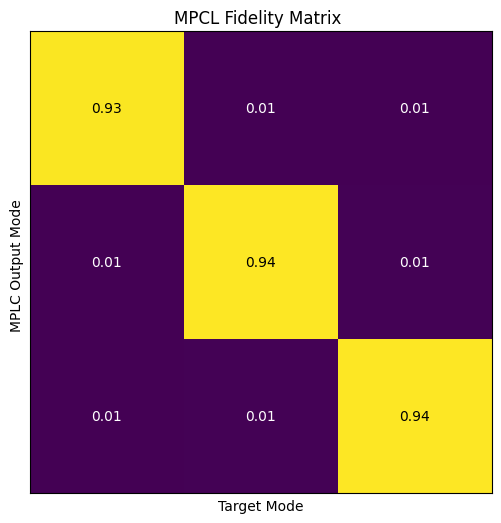

In [4]:
x = np.linspace(-N / 2, N / 2 - 1, N) * delta
y = np.linspace(-N / 2, N / 2 - 1, N) * delta * 1/np.cos(angle)
x, y = np.meshgrid(x, y)
TH,R = bf.cart2pol(x,y)
x0,y0 = bf.pol2cart(TH-np.pi/4,R)


output_modes = generate_hg_modes_array(x0, y0, w_prime,num_modes) #backward
input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)  #forward

for i in range(len(phase_masks),0, -1): 
    output_modes = [ bf.propagate(output_mode,np.conj(H0)) for output_mode in output_modes]
    output_modes = [output_mode * np.exp(1j*np.angle(phase_masks[i - 1])) for output_mode in output_modes]
    pwr_output_modes = [np.sum(np.abs(modes)**2)  for modes in output_modes]
    for i in range(len(output_modes)):
        output_modes[i] = output_modes[i]/np.sqrt(pwr_output_modes[i])
    
final_output = [ bf.propagate(output_mode,np.conj(H0)) for output_mode in output_modes]

mpcl_matrix=[]
for i in range(len(output_modes)):
    for y in range(len(output_modes)):
        mpcl_matrix.append(np.sum((input_modes[y]*np.conj(final_output[i]))))
    
mpcl_matrix = np.array(mpcl_matrix).reshape(num_modes,num_modes)


# Convert MPCL matrix to a NumPy array
mpcl_matrix = np.array(mpcl_matrix)


# Plotting the heatmap of the mpcl_matrix
plt.figure(figsize=(6, 6))
im = plt.imshow(np.abs(mpcl_matrix))


# Adding labels and title
plt.title('MPCL Fidelity Matrix ')
plt.xlabel('Target Mode')
plt.ylabel('MPLC Output Mode ')
plt.xticks([])
plt.yticks([])
# # Loop over data dimensions and create text annotations.
# for i in range(mpcl_matrix.shape[0]):
#     for j in range(mpcl_matrix.shape[1]):
#         text = plt.text(j, i, f"{np.abs(mpcl_matrix[i, j]):.2f}",  # Use absolute values, format to 2 decimal places
#                         ha="center", va="center", color="w")  # Place the text in the center, color white for better visibility

# Loop over data dimensions and create text annotations.
for i in range(mpcl_matrix.shape[0]):
    for j in range(mpcl_matrix.shape[1]):
        value = np.abs(mpcl_matrix[i, j])
        color = "black" if i == j else "white"  # Diagonal entries in black
        plt.text(j, i, f"{value:.2f}", ha="center", va="center", color=color)

# Show the plot
plt.show()
# Show the plot
plt.show()

## Final Outputs

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 8x4 size for side-by-side plots

    # Plot the final_output[i] on the left
ax[0].imshow(sum(np.abs(final_output)**2), cmap='inferno',extent=extent)
ax[0].set_title("MPLC Output")
ax[0].set_xlabel(r'x ($\mu$m)')
ax[0].set_ylabel(r'y ($\mu$m)')

    # Plot the output_modes[i] on the right
ax[1].imshow(sum(np.abs(input_modes)**2), cmap='inferno',extent=extent)
ax[1].set_title("Desired Output")
ax[1].set_xlabel(r'x ($\mu$m)')
ax[1].set_ylabel(r'y ($\mu$m)')

    # Display the plots
plt.tight_layout()  # Adjust layout so titles and labels don't overlap
plt.show()

In [ ]:
for i in range(len(output_modes)):  # Adjust to the length of output_modes or final_output
    # Create subplots: 1 row, 2 columns (side-by-side)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 8x4 size for side-by-side plots

    # Plot the final_output[i] on the left
    ax[0].imshow(np.abs(final_output[i])**2, cmap='inferno',extent=extent)
    ax[0].set_title(f'Output of MPLC {labels[i]}')
    ax[0].set_xlabel(r'x ($\mu$m)')
    ax[0].set_ylabel(r'y ($\mu$m)')
    # Plot the output_modes[i] on the right
    ax[1].imshow(np.abs(input_modes[i])**2, cmap='inferno',extent=extent)
    ax[1].set_title(f'Desired Output of {labels[i]}')
    ax[1].set_xlabel(r'x ($\mu$m)')
    ax[1].set_ylabel(r'y ($\mu$m)')

    # Display the plots
    plt.tight_layout()  # Adjust layout so titles and labels don't overlap
    plt.show()




## Reverse Fidelity

In [ ]:
x = np.linspace(-N / 2, N / 2 - 1, N) * delta
y = np.linspace(-N / 2, N / 2 - 1, N) * delta * 1/np.cos(angle)
x, y = np.meshgrid(x, y)
TH,R = bf.cart2pol(x,y)
x0,y0 = bf.pol2cart(TH-np.pi/4,R)



output_modes = generate_hg_modes_array(x0, y0, w_prime,num_modes) #backward
input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)  #forward


for i in range(0,len(phase_masks), 1): 
    input_modes = [ bf.propagate(input_mode,np.conj(H0)) for input_mode in input_modes]
    input_modes = [input_mode * np.exp(1j*np.angle(phase_masks[i])) for input_mode in input_modes]
    pwr_input_modes = [np.sum(np.abs(modes)**2)  for modes in input_modes]
    for i in range(len(input_modes)):
        input_modes[i] = input_modes[i]/np.sqrt(pwr_input_modes[i])
    
final_output = [ bf.propagate(input_mode,np.conj(H0)) for input_mode in input_modes]

mpcl_matrix=[]
for i in range(len(input_modes)):
    for y in range(len(input_modes)):
        mpcl_matrix.append(np.sum((output_modes[y]*np.conj(final_output[i]))))
    
mpcl_matrix = np.array(mpcl_matrix).reshape(num_modes,num_modes)


# Convert MPCL matrix to a NumPy array
mpcl_matrix = np.array(mpcl_matrix)


# Plotting the heatmap of the mpcl_matrix
plt.figure(figsize=(6, 6))
im = plt.imshow(np.abs(mpcl_matrix))


# Adding labels and title
plt.title('MPCL Fidelity Matrix ')
plt.xlabel('Target Mode')
plt.ylabel('MPLC Output Mode ')
plt.xticks([])
plt.yticks([])
# Loop over data dimensions and create text annotations.
for i in range(mpcl_matrix.shape[0]):
    for j in range(mpcl_matrix.shape[1]):
        text = plt.text(j, i, f"{np.abs(mpcl_matrix[i, j]):.2f}",  # Use absolute values, format to 2 decimal places
                        ha="center", va="center", color="w")  # Place the text in the center, color white for better visibility

# Show the plot
plt.show()

In [ ]:
for i in range(len(output_modes)):  # Adjust to the length of output_modes or final_output
    # Create subplots: 1 row, 2 columns (side-by-side)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 8x4 size for side-by-side plots

    # Plot the final_output[i] on the left
    ax[0].imshow(np.abs(final_output[i])**2, cmap='inferno',extent=extent)
    ax[0].set_title(f'Output of MPLC {labels[i]}')
    ax[0].set_xlabel(r'x ($\mu$m)')
    ax[0].set_ylabel(r'y ($\mu$m)')
    # Plot the output_modes[i] on the right
    ax[1].imshow(np.abs(output_modes[i])**2, cmap='inferno',extent=extent)
    ax[1].set_title(f'Desired Output of {labels[i]}')
    ax[1].set_xlabel(r'x ($\mu$m)')
    ax[1].set_ylabel(r'y ($\mu$m)')

    # Display the plots
    plt.tight_layout()  # Adjust layout so titles and labels don't overlap
    plt.show()




## Misalignments

In [ ]:
x = np.linspace(-N / 2, N / 2 - 1, N) * delta
y = np.linspace(-N / 2, N / 2 - 1, N) * delta * 1/np.cos(angle)
x, y = np.meshgrid(x, y)
TH,R = bf.cart2pol(x,y)
x0,y0 = bf.pol2cart(TH-np.pi/4,R)

output_modes = generate_hg_modes_array(x0, y0, w_prime,num_modes) #backward
input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)  #forward




z_prime = 0.020
H1 = bf.transfer_function_of_free_space(x, y, z, 750e-9)

for i in range(len(phase_masks),0, -1): 
    output_modes = [ bf.propagate(output_mode,np.conj(H1)) for output_mode in output_modes]
    output_modes = [output_mode * np.exp(1j*np.angle(phase_masks[i - 1])) for output_mode in output_modes]
    pwr_output_modes = [np.sum(np.abs(modes)**2)  for modes in output_modes]
    for i in range(len(output_modes)):
        output_modes[i] = output_modes[i]/np.sqrt(pwr_output_modes[i])
    
final_output = [ bf.propagate(output_mode,np.conj(H1)) for output_mode in output_modes]

mpcl_matrix=[]
for i in range(len(output_modes)):
    for y in range(len(output_modes)):
        mpcl_matrix.append(np.sum((input_modes[y]*np.conj(final_output[i]))))
    
mpcl_matrix = np.array(mpcl_matrix).reshape(num_modes,num_modes)


# Convert MPCL matrix to a NumPy array
mpcl_matrix = np.array(mpcl_matrix)


# Plotting the heatmap of the mpcl_matrix
plt.figure(figsize=(6, 6))
im = plt.imshow(np.abs(mpcl_matrix))


# Adding labels and title
plt.title('MPCL Fidelity Matrix ')
plt.xlabel('Target Mode')
plt.ylabel('MPLC Output Mode ')
plt.xticks([])
plt.yticks([])
# Loop over data dimensions and create text annotations.
for i in range(mpcl_matrix.shape[0]):
    for j in range(mpcl_matrix.shape[1]):
        text = plt.text(j, i, f"{np.abs(mpcl_matrix[i, j]):.2f}",  # Use absolute values, format to 2 decimal places
                        ha="center", va="center", color="w")  # Place the text in the center, color white for better visibility

# Show the plot
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 8x4 size for side-by-side plots

    # Plot the final_output[i] on the left
ax[0].imshow(sum(np.abs(final_output)**2), cmap='inferno',extent=extent)
ax[0].set_title("MPLC Output")
ax[0].set_xlabel(r'x ($\mu$m)')
ax[0].set_ylabel(r'y ($\mu$m)')



    # Plot the output_modes[i] on the right
ax[1].imshow(sum(np.abs(input_modes)**2), cmap='inferno',extent=extent)
ax[1].set_title("Desired Output")
ax[1].set_xlabel(r'x ($\mu$m)')
ax[1].set_ylabel(r'y ($\mu$m)')

    # Display the plots
plt.tight_layout()  # Adjust layout so titles and labels don't overlap
plt.show()

In [ ]:
for i in range(len(output_modes)):  # Adjust to the length of output_modes or final_output
    # Create subplots: 1 row, 2 columns (side-by-side)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 8x4 size for side-by-side plots

    # Plot the final_output[i] on the left
    ax[0].imshow(np.abs(final_output[i])**2, cmap='inferno',extent=extent)
    ax[0].set_title(f'Output of MPLC {labels[i]}')
    ax[0].set_xlabel(r'x ($\mu$m)')
    ax[0].set_ylabel(r'y ($\mu$m)')
    # Plot the output_modes[i] on the right
    ax[1].imshow(np.abs(input_modes[i])**2, cmap='inferno',extent=extent)
    ax[1].set_title(f'Desired Output of {labels[i]}')
    ax[1].set_xlabel(r'x ($\mu$m)')
    ax[1].set_ylabel(r'y ($\mu$m)')

    # Display the plots
    plt.tight_layout()  # Adjust layout so titles and labels don't overlap
    plt.show()




### Cross-talk for diffrent z

In [38]:
max_off_diag_list = []  # List to store max off-diagonal values for each iteration
avg_diag_list = []      # List to store average of diagonal absolute values for each iteration

for angle in np.arange(-0.010, 0.010, 0.001):
    x = np.linspace(-N / 2, N / 2 - 1, N) * delta
    y = np.linspace(-N / 2, N / 2 - 1, N) * delta * 1/np.cos(angle)
    x, y = np.meshgrid(x, y)
    TH, R = bf.cart2pol(x, y)
    x0, y0 = bf.pol2cart(TH - np.pi/4, R)

    output_modes = generate_hg_modes_array(x0, y0, w_prime, num_modes)  # backward
    input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)  # forward

    H1 = bf.transfer_function_of_free_space(x, y, z + angle, wvl)

    for idx in range(len(phase_masks), 0, -1): 
        output_modes = [bf.propagate(output_mode, np.conj(H1)) for output_mode in output_modes]
        output_modes = [output_mode * np.exp(1j * np.angle(phase_masks[idx - 1])) for output_mode in output_modes]
        pwr_output_modes = [np.sum(np.abs(mode)**2) for mode in output_modes]
        for j in range(len(output_modes)):
            output_modes[j] = output_modes[j] / np.sqrt(pwr_output_modes[j])

    final_output = [bf.propagate(output_mode, np.conj(H1)) for output_mode in output_modes]

    mpcl_matrix = []
    for i in range(len(output_modes)):
        for j in range(len(output_modes)):
            mpcl_matrix.append(np.sum(input_modes[j] * np.conj(final_output[i])))

    mpcl_matrix = np.array(mpcl_matrix).reshape(num_modes, num_modes)

    # Compute the maximum off-diagonal value of |mpcl_matrix|
    abs_mpcl = np.abs(mpcl_matrix)
    mask = ~np.eye(num_modes, dtype=bool)  # Mask to exclude diagonal entries
    off_diag_values = abs_mpcl[mask]
    max_value = np.max(off_diag_values)
    max_off_diag_list.append(max_value)
    
    # Compute and store the average of the absolute values of the diagonal entries
    avg_diag = np.mean(np.abs(np.diag(mpcl_matrix)))
    avg_diag_list.append(avg_diag)

# Now, max_off_diag_list contains the max off-diagonal values and avg_diag_list contains the average of the diagonal values for each iteration.


In [2]:
# np.savez('data_z.npz', 
#          z_values=z_values, 
#          max_off_diag_list=max_off_diag_list, 
#          avg_diag_list=avg_diag_list)
# import numpy as np
# import matplotlib.pyplot as plt

data = np.load('data_z.npz')

z_values_z = data['z_values']
max_off_diag_list_z = data['max_off_diag_list']
avg_diag_list_z = data['avg_diag_list']

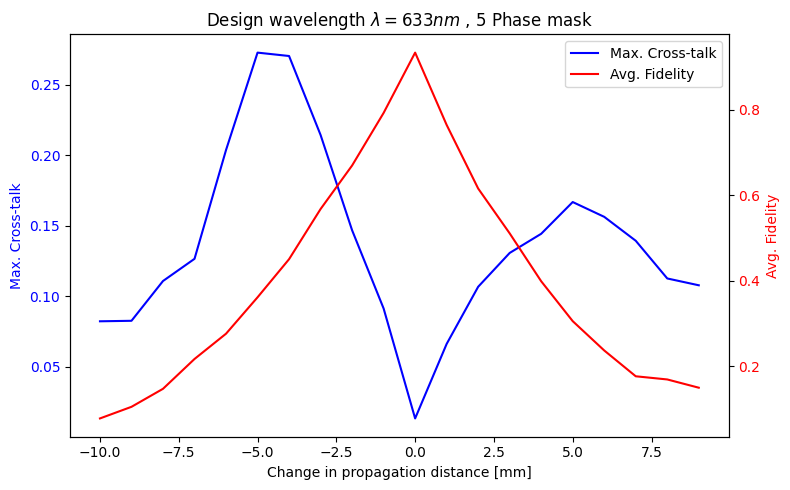

In [3]:

z_values_z = np.arange(-10, 10, 1)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot for max_off_diag_list on the left y-axis
ax1.plot(z_values_z, max_off_diag_list_z, 'b-', label='Max. Cross-talk')
ax1.set_xlabel('Change in propagation distance [mm]')
ax1.set_ylabel('Max. Cross-talk', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for avg_diag_list
ax2 = ax1.twinx()
ax2.plot(z_values_z, avg_diag_list_z, 'r-', label='Avg. Fidelity')
ax2.set_ylabel('Avg. Fidelity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title(f"Design wavelength $\lambda = 633 nm $ , 5 Phase mask " )

plt.tight_layout()
plt.show()


In [5]:
# plt.savefig('histogram2.pgf')

### Cross-talk for diffrent $\lambda$

In [10]:
max_off_diag_list = []  # List to store max off-diagonal values for each iteration
avg_diag_list = []      # List to store average of diagonal absolute values for each iteration

for angle in np.arange(-100e-9, 100e-9, 10e-9):
    x = np.linspace(-N / 2, N / 2 - 1, N) * delta
    y = np.linspace(-N / 2, N / 2 - 1, N) * delta * 1/np.cos(angle)
    x, y = np.meshgrid(x, y)
    TH, R = bf.cart2pol(x, y)
    x0, y0 = bf.pol2cart(TH - np.pi/4, R)

    output_modes = generate_hg_modes_array(x0, y0, w_prime, num_modes)  # backward
    input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)  # forward

    H1 = bf.transfer_function_of_free_space(x, y, z , wvl+ angle)

    for idx in range(len(phase_masks), 0, -1): 
        output_modes = [bf.propagate(output_mode, np.conj(H1)) for output_mode in output_modes]
        output_modes = [output_mode * np.exp(1j * np.angle(phase_masks[idx - 1])) for output_mode in output_modes]
        pwr_output_modes = [np.sum(np.abs(mode)**2) for mode in output_modes]
        for j in range(len(output_modes)):
            output_modes[j] = output_modes[j] / np.sqrt(pwr_output_modes[j])

    final_output = [bf.propagate(output_mode, np.conj(H1)) for output_mode in output_modes]

    mpcl_matrix = []
    for i in range(len(output_modes)):
        for j in range(len(output_modes)):
            mpcl_matrix.append(np.sum(input_modes[j] * np.conj(final_output[i])))

    mpcl_matrix = np.array(mpcl_matrix).reshape(num_modes, num_modes)

    # Compute the maximum off-diagonal value of |mpcl_matrix|
    abs_mpcl = np.abs(mpcl_matrix)
    mask = ~np.eye(num_modes, dtype=bool)  # Mask to exclude diagonal entries
    off_diag_values = abs_mpcl[mask]
    max_value = np.max(off_diag_values)
    max_off_diag_list.append(max_value)
    
    # Compute and store the average of the absolute values of the diagonal entries
    avg_diag = np.mean(np.abs(np.diag(mpcl_matrix)))
    avg_diag_list.append(avg_diag)

# Now, max_off_diag_list contains the max off-diagonal values and avg_diag_list contains the average of the diagonal values for each iteration.


In [5]:
# np.savez('data_wvl.npz', 
#          z_values=z_values, 
#          max_off_diag_list=max_off_diag_list, 
#          avg_diag_list=avg_diag_list)


data = np.load('data_wvl.npz')

z_values_wvl = data['z_values']
max_off_diag_list_wvl = data['max_off_diag_list']
avg_diag_list_wvl = data['avg_diag_list']

In [7]:

z_values_wvl = np.arange(633-100, 633+100,10)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot for max_off_diag_list on the left y-axis
ax1.plot(z_values_wvl, max_off_diag_list_wvl, 'b-', label='Max. Cross-talk')
ax1.set_xlabel(r' Wavelength $\lambda$ [nm]')
ax1.set_ylabel('Max. Cross-talk', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# #vertical line 
# ax1.axvline(x=633, color='gray', linestyle='--', linewidth=1)
# ax1.text(633 + 1, ax1.get_ylim()[1]*0.95, '633 nm', rotation=90, color='gray')

# Create a second y-axis for avg_diag_list
ax2 = ax1.twinx()
ax2.plot(z_values_wvl, avg_diag_list_wvl, 'r-', label='Avg. Fidelity')
ax2.set_ylabel('Avg. Fidelity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# plt.title(f"Design wavelength $\lambda = 633 nm $ , {len(phase_masks)} Phase mask " )
plt.title(f"Design wavelength $\lambda = 633 nm $ , 5 Phase mask " )

# ax1.text(0.95, 0.95, f'Design $\lambda$=633nm, {len(phase_masks)} Phase Mask',
#          transform=ax1.transAxes, fontsize=8,
#          verticalalignment='top', horizontalalignment='right',
#          bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


C:\Users\Nickolay\AppData\Local\Temp\ipykernel_19568\3917898992.py:35: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [8]:
plt.savefig('histogram2.pgf')

### Cross-talk for different beam size

In [17]:
max_off_diag_list = []  # List to store max off-diagonal values for each iteration
avg_diag_list = []      # List to store average of diagonal absolute values for each iteration

for angle in np.arange(-20e-6, 20e-6, 2e-6):
    x = np.linspace(-N / 2, N / 2 - 1, N) * delta
    y = np.linspace(-N / 2, N / 2 - 1, N) * delta * 1/np.cos(angle)
    x, y = np.meshgrid(x, y)
    TH, R = bf.cart2pol(x, y)
    x0, y0 = bf.pol2cart(TH - np.pi/4, R)

    output_modes = generate_hg_modes_array(x0, y0, w_prime, num_modes)  # backward
    input_modes = create_gaussian_beams_array(x, y, w+angle, d, central_shift, num_modes)  # forward

    H1 = bf.transfer_function_of_free_space(x, y, z, wvl)

    for idx in range(len(phase_masks), 0, -1): 
        output_modes = [bf.propagate(output_mode, np.conj(H1)) for output_mode in output_modes]
        output_modes = [output_mode * np.exp(1j * np.angle(phase_masks[idx - 1])) for output_mode in output_modes]
        pwr_output_modes = [np.sum(np.abs(mode)**2) for mode in output_modes]
        for j in range(len(output_modes)):
            output_modes[j] = output_modes[j] / np.sqrt(pwr_output_modes[j])

    final_output = [bf.propagate(output_mode, np.conj(H1)) for output_mode in output_modes]

    mpcl_matrix = []
    for i in range(len(output_modes)):
        for j in range(len(output_modes)):
            mpcl_matrix.append(np.sum(input_modes[j] * np.conj(final_output[i])))

    mpcl_matrix = np.array(mpcl_matrix).reshape(num_modes, num_modes)

    # Compute the maximum off-diagonal value of |mpcl_matrix|
    abs_mpcl = np.abs(mpcl_matrix)
    mask = ~np.eye(num_modes, dtype=bool)  # Mask to exclude diagonal entries
    off_diag_values = abs_mpcl[mask]
    max_value = np.max(off_diag_values)
    max_off_diag_list.append(max_value)
    
    # Compute and store the average of the absolute values of the diagonal entries
    avg_diag = np.mean(np.abs(np.diag(mpcl_matrix)))
    avg_diag_list.append(avg_diag)

# Now, max_off_diag_list contains the max off-diagonal values and avg_diag_list contains the average of the diagonal values for each iteration.


In [18]:
np.savez('data_beam.npz', 
         z_values=z_values, 
         max_off_diag_list=max_off_diag_list, 
         avg_diag_list=avg_diag_list)
import numpy as np
import matplotlib.pyplot as plt

data = np.load('data_beam.npz')

z_values_beam = data['z_values']
max_off_diag_list_beam = data['max_off_diag_list']
avg_diag_list_beam = data['avg_diag_list']

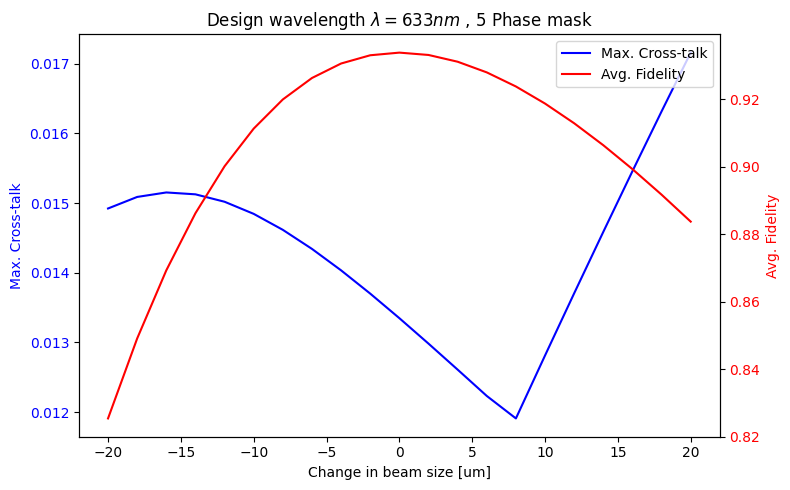

In [23]:

z_values_beam = np.arange(-20, 21, 2)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot for max_off_diag_list on the left y-axis
ax1.plot(z_values_beam, max_off_diag_list_beam, 'b-', label='Max. Cross-talk')
ax1.set_xlabel('Change in beam size [um]')
ax1.set_ylabel('Max. Cross-talk', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for avg_diag_list
ax2 = ax1.twinx()
ax2.plot(z_values_beam, avg_diag_list_beam, 'r-', label='Avg. Fidelity')
ax2.set_ylabel('Avg. Fidelity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title(f"Design wavelength $\lambda = 633 nm $ , 5 Phase mask " )

plt.tight_layout()
plt.show()


### Merging Figure

C:\Users\Nickolay\AppData\Local\Temp\ipykernel_14504\2588978840.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


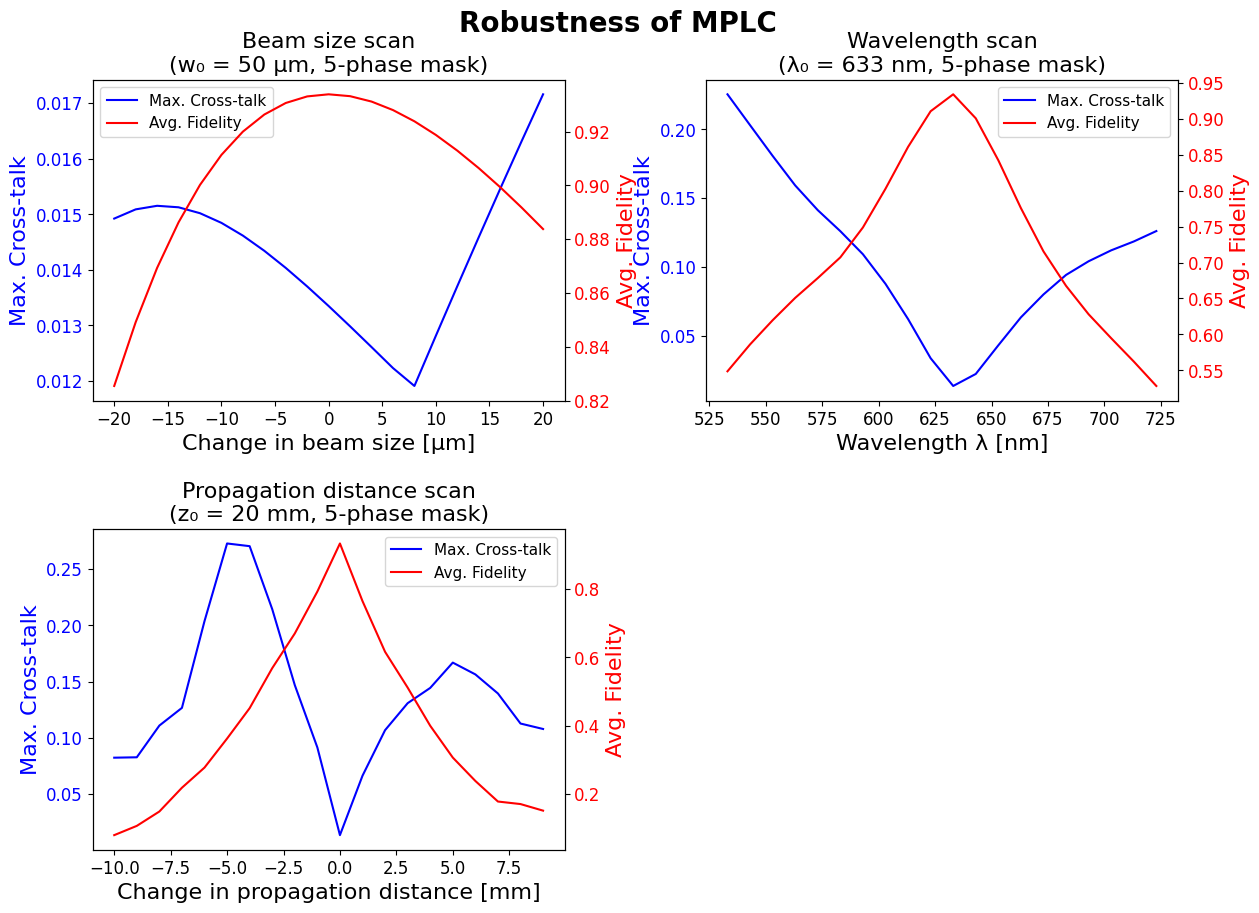

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# ——————————————
#  Global font settings
# ——————————————
plt.rcParams.update({
    'font.size':       12,   # base font size
    'axes.titlesize':  16,   # subplot titles
    'axes.labelsize':  16,   # x/y labels
    'legend.fontsize': 11,   # legend text
    'xtick.labelsize': 12,   # tick labels
    'ytick.labelsize': 12,
})

# your data arrays
z_values_beam     = np.arange(-20, 21, 2)
max_off_diag_beam = max_off_diag_list_beam
avg_diag_beam     = avg_diag_list_beam

z_values_wvl      = np.arange(633-100, 633+100, 10)
max_off_diag_wvl  = max_off_diag_list_wvl
avg_diag_wvl      = avg_diag_list_wvl

z_values_z        = np.arange(-10, 10, 1)
max_off_diag_z    = max_off_diag_list_z
avg_diag_z        = avg_diag_list_z

# create figure + GridSpec
fig = plt.figure(figsize=(14, 10))
gs  = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.4, wspace=0.3)

# —— top-left: beam-size scan —— #
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(z_values_beam, max_off_diag_beam, 'b-', label='Max. Cross-talk')
ax1.set_xlabel('Change in beam size [μm]')
ax1.set_ylabel('Max. Cross-talk', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax1b = ax1.twinx()
ax1b.plot(z_values_beam, avg_diag_beam, 'r-', label='Avg. Fidelity')
ax1b.set_ylabel('Avg. Fidelity', color='r')
ax1b.tick_params(axis='y', labelcolor='r')

lines1, labels1   = ax1.get_legend_handles_labels()
lines1b, labels1b = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines1b, labels1 + labels1b, loc='upper left')

ax1.set_title('Beam size scan\n(w₀ = 50 μm, 5-phase mask)')

# —— top-right: wavelength scan —— #
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(z_values_wvl, max_off_diag_wvl, 'b-', label='Max. Cross-talk')
ax2.set_xlabel('Wavelength λ [nm]')
ax2.set_ylabel('Max. Cross-talk', color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax2b = ax2.twinx()
ax2b.plot(z_values_wvl, avg_diag_wvl, 'r-', label='Avg. Fidelity')
ax2b.set_ylabel('Avg. Fidelity', color='r')
ax2b.tick_params(axis='y', labelcolor='r')

lines2, labels2   = ax2.get_legend_handles_labels()
lines2b, labels2b = ax2b.get_legend_handles_labels()
ax2.legend(lines2 + lines2b, labels2 + labels2b, loc='upper right')

ax2.set_title('Wavelength scan\n(λ₀ = 633 nm, 5-phase mask)')

# —— bottom (spanning both cols): z-scan —— #
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(z_values_z, max_off_diag_z, 'b-', label='Max. Cross-talk')
ax3.set_xlabel('Change in propagation distance [mm]')
ax3.set_ylabel('Max. Cross-talk', color='b')
ax3.tick_params(axis='y', labelcolor='b')

ax3b = ax3.twinx()
ax3b.plot(z_values_z, avg_diag_z, 'r-', label='Avg. Fidelity')
ax3b.set_ylabel('Avg. Fidelity', color='r')
ax3b.tick_params(axis='y', labelcolor='r')

lines3, labels3   = ax3.get_legend_handles_labels()
lines3b, labels3b = ax3b.get_legend_handles_labels()
ax3.legend(lines3 + lines3b, labels3 + labels3b, loc='upper right')

ax3.set_title('Propagation distance scan\n(z₀ = 20 mm, 5-phase mask)')

# overall title
fig.suptitle('Robustness of MPLC', fontsize=20, fontweight='bold', y=0.95)

plt.tight_layout()
plt.show()


In [72]:
import numpy as np
import matplotlib.pyplot as plt

# ————————————————————————————————
# 1) Beam-size scan → beam_scan.pdf
# ————————————————————————————————
z_values_beam     = np.arange(-20, 21, 2)
max_off_diag_beam = max_off_diag_list_beam
avg_diag_beam     = avg_diag_list_beam

fig, ax1 = plt.subplots(figsize=(7, 5))
ax1.plot(z_values_beam, max_off_diag_beam, 'b-', label='Max. Cross-talk')
ax1.set_xlabel('Change in beam size [μm]')
ax1.set_ylabel('Max. Cross-talk', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax1b = ax1.twinx()
ax1b.plot(z_values_beam, avg_diag_beam, 'r-', label='Avg. Fidelity')
ax1b.set_ylabel('Avg. Fidelity', color='r')
ax1b.tick_params(axis='y', labelcolor='r')

lines, labels   = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

ax1.set_title('Beam size scan\n(w₀ = 50 μm, 5-phase mask)')
fig.tight_layout()
fig.savefig('beam_scan.pdf', bbox_inches='tight')
plt.close(fig)


# ————————————————————————————————
# 2) Wavelength scan → wavelength_scan.pdf
# ————————————————————————————————
z_values_wvl     = np.arange(633-100, 633+100, 10)
max_off_diag_wvl = max_off_diag_list_wvl
avg_diag_wvl     = avg_diag_list_wvl

fig, ax2 = plt.subplots(figsize=(7, 5))
ax2.plot(z_values_wvl, max_off_diag_wvl, 'b-', label='Max. Cross-talk')
ax2.set_xlabel('Wavelength λ [nm]')
ax2.set_ylabel('Max. Cross-talk', color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax2b = ax2.twinx()
ax2b.plot(z_values_wvl, avg_diag_wvl, 'r-', label='Avg. Fidelity')
ax2b.set_ylabel('Avg. Fidelity', color='r')
ax2b.tick_params(axis='y', labelcolor='r')

lines, labels   = ax2.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

ax2.set_title('Wavelength scan\n(λ₀ = 633 nm, 5-phase mask)')
fig.tight_layout()
fig.savefig('wavelength_scan.pdf', bbox_inches='tight')
plt.close(fig)


# ————————————————————————————————
# 3) Propagation-distance scan → z_scan.pdf
# ————————————————————————————————
z_values_z     = np.arange(-10, 10, 1)
max_off_diag_z = max_off_diag_list_z
avg_diag_z     = avg_diag_list_z

fig, ax3 = plt.subplots(figsize=(7, 5))
ax3.plot(z_values_z, max_off_diag_z, 'b-', label='Max. Cross-talk')
ax3.set_xlabel('Change in propagation distance [mm]')
ax3.set_ylabel('Max. Cross-talk', color='b')
ax3.tick_params(axis='y', labelcolor='b')

ax3b = ax3.twinx()
ax3b.plot(z_values_z, avg_diag_z, 'r-', label='Avg. Fidelity')
ax3b.set_ylabel('Avg. Fidelity', color='r')
ax3b.tick_params(axis='y', labelcolor='r')

lines, labels   = ax3.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc='upper right')

ax3.set_title('Propagation distance scan\n(z₀ = 20 mm, 5-phase mask)')
fig.tight_layout()
fig.savefig('z_scan.pdf', bbox_inches='tight')
plt.close(fig)


### Wavelength Dependence Image

In [ ]:

# Loop over shifts
for shift in np.arange(-200e-9, 200e-9, 50e-9):
    # Define spatial grids
    x = np.linspace(-N / 2, N / 2 - 1, N) * delta
    y = np.linspace(-N / 2, N / 2 - 1, N) * delta / np.cos(angle)
    x, y = np.meshgrid(x, y)
    
    # Convert to polar coordinates and rotate by 45 degrees (pi/4)
    TH, R = bf.cart2pol(x, y)
    x0, y0 = bf.pol2cart(TH - np.pi/4, R)
    
    # Generate the mode arrays (backward and forward propagation)
    output_modes = generate_hg_modes_array(x0, y0, w_prime, num_modes)
    input_modes = create_gaussian_beams_array(x, y, w, d, central_shift, num_modes)
    
    # Calculate the transfer function for free space with the current wavelength shift
    H1 = bf.transfer_function_of_free_space(x, y, z, wvl + shift)
    
    # Propagate the output modes backwards through the phase masks in reverse order
    for mask_index in range(len(phase_masks), 0, -1):
        # Propagate through free space (using the conjugated transfer function)
        output_modes = [bf.propagate(mode, np.conj(H1)) for mode in output_modes]
        # Apply the phase mask
        output_modes = [mode * np.exp(1j * np.angle(phase_masks[mask_index - 1])) for mode in output_modes]
        # Normalize each mode
        pwr_output_modes = [np.sum(np.abs(mode)**2) for mode in output_modes]
        output_modes = [mode / np.sqrt(pwr) for mode, pwr in zip(output_modes, pwr_output_modes)]
    
    # Final propagation step
    final_output = [bf.propagate(mode, np.conj(H1)) for mode in output_modes]
   
    plt.imshow(sum(np.abs(final_output)**2), cmap="inferno", extent=extent)
    plt.title(f"{(wvl+shift)*1e9:.2f} nm")
    plt.xlabel('x (µm)')
    plt.ylabel('y (µm)')
    
    plt.tight_layout()
    plt.show()


## Shifted Beam Location

In [ ]:
x = np.linspace(-N / 2, N / 2 - 1, N) * delta
y = np.linspace(-N / 2, N / 2 - 1, N) * delta * 1/np.cos(angle)
x, y = np.meshgrid(x, y)
TH,R = bf.cart2pol(x,y)
x0,y0 = bf.pol2cart(TH-np.pi/4,R)



central_shift_prime= central_shift*1.1

diff_shift = (central_shift_prime - central_shift)*10**6 #[um]

all_gaussian_beams = sum(create_gaussian_beams_array(x, y, w, d, central_shift, num_modes))
all_gaussian_beams_prime = sum(create_gaussian_beams_array(x, y, w, d, central_shift_prime, num_modes))



fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 8x4 size for side-by-side plots

    # Plot the final_output[i] on the left
ax[0].imshow(np.abs(all_gaussian_beams)**2, cmap='inferno',extent=extent)
ax[0].set_title("Original Location")
ax[0].set_xlabel(r'x ($\mu$m)')
ax[0].set_ylabel(r'y ($\mu$m)')

    # Plot the output_modes[i] on the right
ax[1].imshow(np.abs(all_gaussian_beams_prime)**2, cmap='inferno',extent=extent)
ax[1].set_title(f"Shifted Location {diff_shift:.2f} µm")
ax[1].set_xlabel(r'x ($\mu$m)')
ax[1].set_ylabel(r'y ($\mu$m)')

    # Display the plots
plt.tight_layout()  # Adjust layout so titles and labels don't overlap
plt.show()

In [ ]:
x = np.linspace(-N / 2, N / 2 - 1, N) * delta
y = np.linspace(-N / 2, N / 2 - 1, N) * delta * 1/np.cos(angle)
x, y = np.meshgrid(x, y)
TH,R = bf.cart2pol(x,y)
x0,y0 = bf.pol2cart(TH-np.pi/4,R)



output_modes = generate_hg_modes_array(x0, y0, w_prime,num_modes) #backward
input_modes = create_gaussian_beams_array(x, y, w, d, central_shift_prime, num_modes)  #forward


for i in range(0,len(phase_masks), 1): 
    input_modes = [ bf.propagate(input_mode,np.conj(H0)) for input_mode in input_modes]
    input_modes = [input_mode * np.exp(1j*np.angle(phase_masks[i])) for input_mode in input_modes]
    pwr_input_modes = [np.sum(np.abs(modes)**2)  for modes in input_modes]
    for i in range(len(input_modes)):
        input_modes[i] = input_modes[i]/np.sqrt(pwr_input_modes[i])
    
final_output = [ bf.propagate(input_mode,np.conj(H0)) for input_mode in input_modes]

mpcl_matrix=[]
for i in range(len(input_modes)):
    for y in range(len(input_modes)):
        mpcl_matrix.append(np.sum((output_modes[y]*np.conj(final_output[i]))))
    
mpcl_matrix = np.array(mpcl_matrix).reshape(num_modes,num_modes)


# Convert MPCL matrix to a NumPy array
mpcl_matrix = np.array(mpcl_matrix)


# Plotting the heatmap of the mpcl_matrix
plt.figure(figsize=(6, 6))
im = plt.imshow(np.abs(mpcl_matrix))


# Adding labels and title
plt.title('MPCL Fidelity Matrix ')
plt.xlabel('Target Mode')
plt.ylabel('MPLC Output Mode ')
plt.xticks([])
plt.yticks([])
# Loop over data dimensions and create text annotations.
for i in range(mpcl_matrix.shape[0]):
    for j in range(mpcl_matrix.shape[1]):
        text = plt.text(j, i, f"{np.abs(mpcl_matrix[i, j]):.2f}",  # Use absolute values, format to 2 decimal places
                        ha="center", va="center", color="w")  # Place the text in the center, color white for better visibility

# Show the plot
plt.show()

In [ ]:
for i in range(len(output_modes)):  # Adjust to the length of output_modes or final_output
    # Create subplots: 1 row, 2 columns (side-by-side)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 8x4 size for side-by-side plots

    # Plot the final_output[i] on the left
    ax[0].imshow(np.abs(final_output[i])**2, cmap='inferno',extent=extent)
    ax[0].set_title(f'Output of MPLC {labels[i]}')
    ax[0].set_xlabel(r'x ($\mu$m)')
    ax[0].set_ylabel(r'y ($\mu$m)')
    # Plot the output_modes[i] on the right
    ax[1].imshow(np.abs(output_modes[i])**2, cmap='inferno',extent=extent)
    ax[1].set_title(f'Desired Output of {labels[i]}')
    ax[1].set_xlabel(r'x ($\mu$m)')
    ax[1].set_ylabel(r'y ($\mu$m)')

    # Display the plots
    plt.tight_layout()  # Adjust layout so titles and labels don't overlap
    plt.show()


